Test for Unet

In [7]:
import tensorflow as tf
import keras

Sample Unet Architecture

In [8]:
inputs = tf.keras.layers.Input((128,128,3))

inp = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#first conv layer
#the encoding layers
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(inp)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(p1)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(p2)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(p3)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(p4)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c5)

#decoding path (upsampling path)
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(u6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c6)


u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(u7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(u8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(u9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(c9)

#output layers which will produce the mask from the c9 layer
output = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)


Preparing the training data

Resizing training images and masks


100%|██████████| 670/670 [02:21<00:00,  4.74it/s]


Resizing test images


100%|██████████| 65/65 [00:00<00:00, 74.46it/s]


Done!


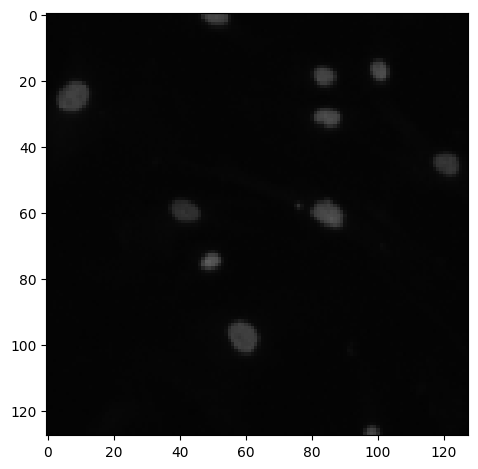

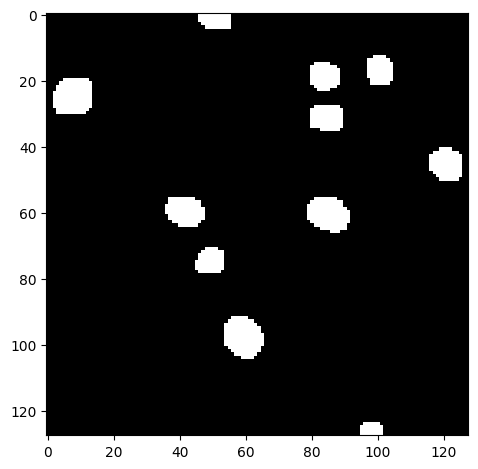

In [9]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

Training the model

In [18]:
model = tf.keras.Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])])

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25)


Epoch 1/25


2023-04-07 21:53:55.195765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9701 - io_u_1: 0.0022

2023-04-07 21:54:24.614576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 34s 869ms/step - loss: 0.0744 - accuracy: 0.9701 - io_u_1: 0.0022 - val_loss: 0.0894 - val_accuracy: 0.9676 - val_io_u_1: 0.0054
Epoch 2/25
35/38 [==========================>...] - ETA: 2s - loss: 0.0577 - accuracy: 0.9763 - io_u_1: 0.0143

KeyboardInterrupt: 

3/3 [==============================] - 0s 59ms/step


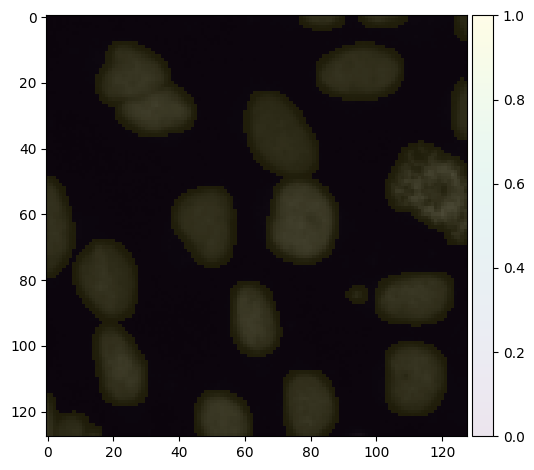

In [22]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
imshow(np.squeeze(preds_val_t[ix]), alpha=0.1)
plt.show()